# Geko Fitting Demo: Simplified Usage

This notebook demonstrates how to use `geko` to fit JWST grism spectroscopy data using a simple Python interface.

## Overview

`geko` is a Python package for analyzing JWST grism spectroscopy and morphology data. It uses:
- **JAX** for accelerated numerical computation
- **Numpyro** for Bayesian inference via MCMC
- **Kinematic models** to fit galaxy rotation curves

## Required Data Structure

All data files should be organized in a single base directory (specified by `save_runs_path`). The code expects the following structure:

### Directory Structure

```
<save_runs_path>/                     # Base directory (e.g., 'fitting_results/')
├── <output_name>/                    # Subfolder for your specific galaxy/run
│   ├── <grism_file>.fits             # 2D grism spectrum (required)
│   └── <ID>_output                   # Fit results (generated after run)
├── morph_fits/                       # Morphology results directory
│   └── <pysersic_file>.cat           # PySersic Sersic profile fits
├── psfs/                             # PSF files directory
│   └── <your_psf>.fits               # Your PSF file
└── catalogs/                         # Optional: catalog directory
    └── <master_catalog>.cat          # Master catalog (can be anywhere)
```

**Example**: If you set:
- `save_runs_path='/path/to/data/'`
- `output_name='my_galaxy'`
- `source_id=12345`
- `manual_grism_file='my_grism_spectrum.fits'`
- `manual_psf_name='my_psf.fits'`
- `manual_pysersic_file='my_morphology.cat'`
- `manual_theta_rot=45.0`

The code will look for:
- Grism spectrum: `/path/to/data/my_galaxy/my_grism_spectrum.fits`
- Morphology: `/path/to/data/morph_fits/my_morphology.cat`
- PSF: `/path/to/data/psfs/my_psf.fits`
- Rotation angle: 45.0 degrees
- Results saved to: `/path/to/data/my_galaxy/12345_output`

### Required Files

#### 1. Master Catalog File

An ASCII table containing source properties. Path specified as `master_cat` parameter (can be located anywhere).

Required columns:
- `ID`: Source identifier (must match your `source_id`)
- `zspec`: Spectroscopic redshift
- `<line>_lambda`: Observed wavelength of emission line (e.g., `H_alpha_lambda` for H-alpha at 6562.8 Å)
- `fit_flux_cgs`: Log of integrated emission line flux (log erg/s/cm²)
- `fit_flux_cgs_e`: Error on log flux

#### 2. Grism Spectrum FITS File

Located at: `<save_runs_path>/<output_name>/<grism_file>.fits`

Specify your filename via `manual_grism_file` parameter.

**FITS File Structure:**

The grism spectrum FITS file must contain the following extensions and headers:

**Extension 0 (Primary Header):**
- Header: `RA0` - Right ascension of target (degrees)
- Header: `DEC0` - Declination of target (degrees)

**Extension 'SPEC2D' (2D Spectrum):**
- Data: 2D array of flux values (spatial position × wavelength)
- Header: `WAVE_1` - Wavelength of first pixel (microns)
- Header: `D_WAVE` - Wavelength step per pixel (microns)
- Header: `NAXIS1` - Number of wavelength pixels
- Header: `NAXIS2` - Number of spatial pixels

**Extension 'WHT2D' (Weight/Error Map):**
- Data: 2D array of inverse variance weights (1/σ²)
- Same dimensions as SPEC2D extension

**Extension 5 (Grism Configuration Table):**
- Column: `module` - Array of NIRCam module identifiers ('A' or 'B')
- Column: `pupil` - Array of grism pupil identifiers ('R' for row dispersion, 'C' for column dispersion)

**Note:** Only `pupil='R'` (row dispersion) is currently supported. The code will raise an error if `pupil='C'` is detected. Module B data is automatically handled by flipping the spectrum along the wavelength axis.

#### 3. PySersic Morphology File

Located at: `<save_runs_path>/morph_fits/<pysersic_file>.cat`

Specify your filename via `manual_pysersic_file` parameter.

ASCII catalog from [PySersic](https://github.com/astropath/pysersic) fits containing:
- Sersic index (n)
- Effective radius (r_eff)
- Position angle (PA)
- Axis ratio (q)
- Centroid positions (x0, y0)

These morphological parameters are used to set priors for the kinematic fitting.

#### 4. PSF File

Located at: `<save_runs_path>/psfs/<psf_file>.fits`

Specify your filename via `manual_psf_name` parameter.

Point spread function FITS file for your grism observations.

#### 5. Rotation Angle (theta)

The rotation angle aligns the morphological model (from imaging) with the grism orientation. Specify via `manual_theta_rot` parameter (in degrees).

## Field Options

The recommended mode is `field='manual'`, which allows you to specify custom file paths for all inputs.

**Predefined fields** are also available for specific JWST programs (`GOODS-N`, `GOODS-N-CONGRESS`, `GOODS-S-FRESCO`), which automatically select PSF files, rotation angles, and file naming conventions. These are primarily for internal use with specific survey data.

## Running the Fit

Once you have prepared all required files, running the fit is straightforward:

In [1]:
# Import required modules
from geko.fitting import run_geko_fit
from geko.config import FitConfiguration

# JAX configuration
import jax
jax.config.update('jax_enable_x64', True)

print("Imports successful!")

Imports successful!


### Basic Usage

In [2]:
#load the geko folder path
# geko_path = '/path/to/geko/'  # Change this to your geko folder path
geko_path = '/Users/lola/geko/'  # Change this to your geko folder path

In [3]:
# Define parameters
source_id = 191250                      # Source ID in your catalog
field = 'manual'                        # Field name: use 'manual' to specify custom files
output_name = 'my_galaxy'              # Name of output folder
master_catalog = geko_path + 'demo/simple_fit_demo_files/catalogs/my_galaxies_cat'  # Path to master catalog
emission_line = 'H_alpha'                   # Emission line wavelength (Angstroms, rest frame)
parametric = True                      # Use parametric Sersic morphology
save_runs_path = geko_path + 'demo/simple_fit_demo_files/'    # Where to save results

# Manual field parameters (required when field='manual')
manual_psf_name = 'webbPSF_F444W.fits'           # PSF filename in psfs/ directory #this is the simple PSF generated with webbpsf, 
                                                 # users can ues their own PSF which is most accurate for their data
manual_theta_rot = 0.0                                     # Rotation angle in degrees (GOODS-S value)
manual_pysersic_file = 'summary_191250_image_F150W_svi.cat'  # PySersic file in morph_fits/
manual_grism_file = 'spec_2d_FRESCO_F444W_ID191250_comb.fits'  # Grism spectrum in output/ directory

# Optional parameters (with defaults)
grism_filter = 'F444W'                 # Grism filter
delta_wave_cutoff = 0.02             # Wavelength bin size (microns)
factor = 1                             # Spatial oversampling factor (set low for demo speed- typically 5)
wave_factor = 1                       # Wavelength oversampling factor (set low for demo speed- typically 9)
model_name = 'Disk'                    # Kinematic model type

# MCMC parameters
num_chains = 1                       # Number of MCMC chains
num_warmup = 100                       # Warmup iterations
num_samples = 100
                     # Sampling iterations

In [4]:
# Run the fit with manual field option
inference_data = run_geko_fit(
    output=output_name,
    master_cat=master_catalog,
    line=emission_line,
    parametric=parametric,
    save_runs_path=save_runs_path,
    num_chains=num_chains,
    num_warmup=num_warmup,
    num_samples=num_samples,
    source_id=source_id,
    field=field,                        # 'manual' mode
    grism_filter=grism_filter,
    delta_wave_cutoff=delta_wave_cutoff,
    factor=factor,
    wave_factor=wave_factor,
    model_name=model_name,
    config=None,                        # Optional: custom configuration
    # Manual field parameters (required when field='manual')
    manual_psf_name=manual_psf_name,
    manual_theta_rot=manual_theta_rot,
    manual_pysersic_file=manual_pysersic_file,
    manual_grism_file=manual_grism_file
)

Cont sub done
Flipping map! (Mod B)
(15, 15)
Module B detected: Flipping dispersion coefficient b01 from -1018.1000 to 1018.1000
Disk model created
Disk object created
Rotating the prior by  0.0  radians, from  2.964  radians to  2.964  radians
Setting parametric priors:  10.175309523224001 59.206811076802936 3.342 1.297 0.18970094750436658 15.165 15.0425
MCMC settings: 1 chains, 100 samples, 50 warmup, max_tree_depth=10, target_accept=0.8
step size:  0.1
warmup:  50
samples:  100


sample: 100%|██████████| 150/150 [03:09<00:00,  1.26s/it, 31 steps of size 1.22e-01. acc. prob=0.92] 


done

                          mean       std    median      5.0%     95.0%     n_eff     r_hat
         unscaled_PA     -2.56      0.80     -2.62     -3.67     -1.30    101.74      0.99
   unscaled_PA_morph      0.06      0.95      0.01     -1.24      1.78     51.77      0.99
         unscaled_Va      0.71      0.03      0.71      0.67      0.77     14.62      0.99
  unscaled_amplitude      0.81      0.05      0.81      0.76      0.89     82.62      0.99
          unscaled_i      1.76      0.83      1.76      0.30      3.02    177.35      0.99
          unscaled_n     -0.92      0.01     -0.92     -0.94     -0.90    108.61      0.99
      unscaled_r_eff      0.82      0.04      0.82      0.76      0.87     56.46      1.01
        unscaled_r_t      0.63      0.16      0.60      0.43      0.90     13.84      1.00
     unscaled_sigma0      0.03      0.03      0.03      0.00      0.07     77.69      0.99
         unscaled_v0     -1.24      0.56     -1.25     -2.02     -0.36     61.91    

<Figure size 1000x1000 with 0 Axes>

## Understanding the Output

After the fit completes, `geko` saves several output files in the directory:
`<save_runs_path>/<output_name>/`

**All output files are named using the source ID**, not the folder name. This allows you to use
any folder name (like 'my_galaxy') while keeping files organized by source ID.

### Output Files

1. **`<source_id>_output`** (NetCDF file)
   - Contains the full MCMC posterior samples and prior samples
   - Can be loaded with `arviz.InferenceData.from_netcdf()`
   - Includes all fitted parameters: Va, sigma0, PA, inc, r_eff, n, xc, yc, amplitude

2. **`<source_id>_results`** (ASCII table)
   - Summary statistics for all fitted parameters
   - Contains median values and 16th/84th percentiles (1-sigma uncertainties)
   - Includes derived quantities like v_re (velocity at effective radius)

3. **`<source_id>_summary.png`** (Diagnostic plot)
   - Multi-panel figure showing:
     - Observed 2D spectrum
     - Best-fit model spectrum
     - Residuals (observed - model)
     - 1D velocity and dispersion profiles
     - Rotation curve and fit parameters

4. **`<source_id>_v_sigma_corner.png`** (Corner plot)
   - Posterior distributions for v/σ ratio
   - Shows correlations between velocity and dispersion

Let's load and examine these outputs:

In [5]:
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import Image, display
import os

# Construct output directory path
output_dir = os.path.join(save_runs_path, output_name)

In [6]:
# Load and display the fit results table
import numpy as np
from astropy.table import Table

fit_results_file = os.path.join(output_dir, f'{source_id}_results')
if os.path.exists(fit_results_file):
    fit_results = Table.read(fit_results_file, format='ascii')
    print("\n" + "=" * 60)
    print("Fit Results Summary")
    print("=" * 60)
    print(fit_results)
else:
    print(f"Fit results file not found: {fit_results_file}")


Fit Results Summary
   ID          PA_50       ...        n_16               n_84       
-------- ----------------- ... ------------------ ------------------
191250.0 6.118682355483754 ... 0.3643496813422901 0.3896656002745919



Model Fit Summary Plot


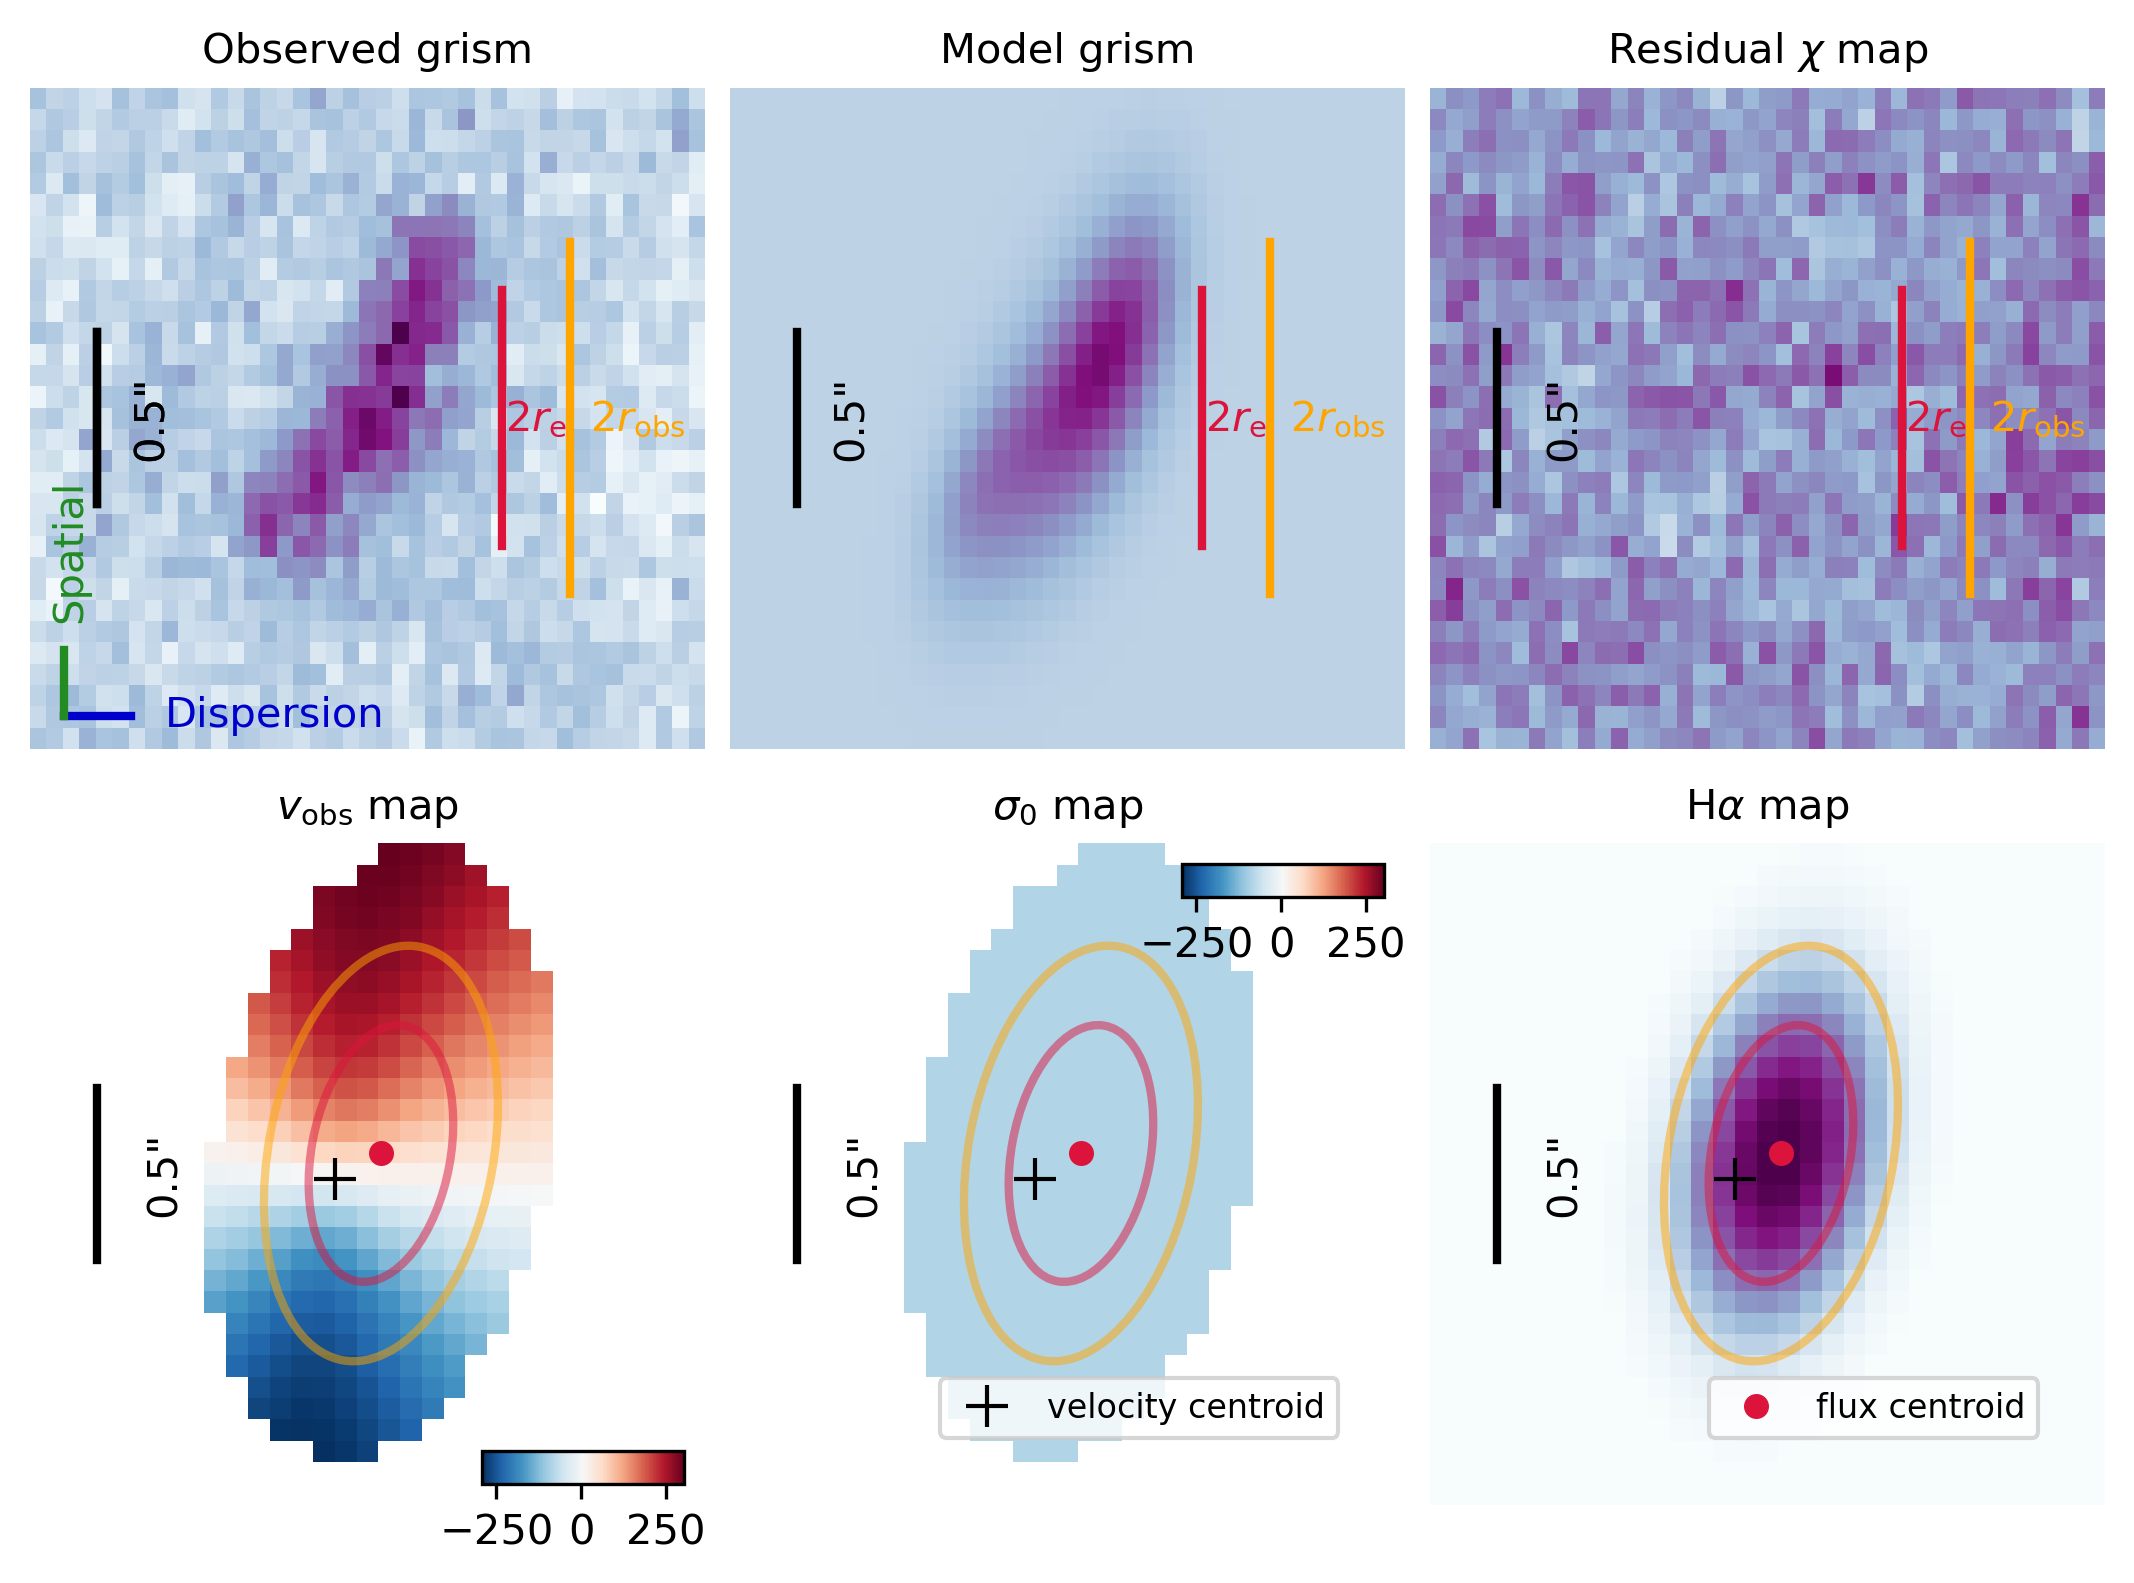

In [7]:
# Display the summary diagnostic plot
summary_plot = os.path.join(output_dir, f'{source_id}_summary.png')
if os.path.exists(summary_plot):
    print("\n" + "=" * 60)
    print("Model Fit Summary Plot")
    print("=" * 60)
    display(Image(filename=summary_plot, width=800))
else:
    print(f"Summary plot not found: {summary_plot}")


v/σ Posterior Distribution


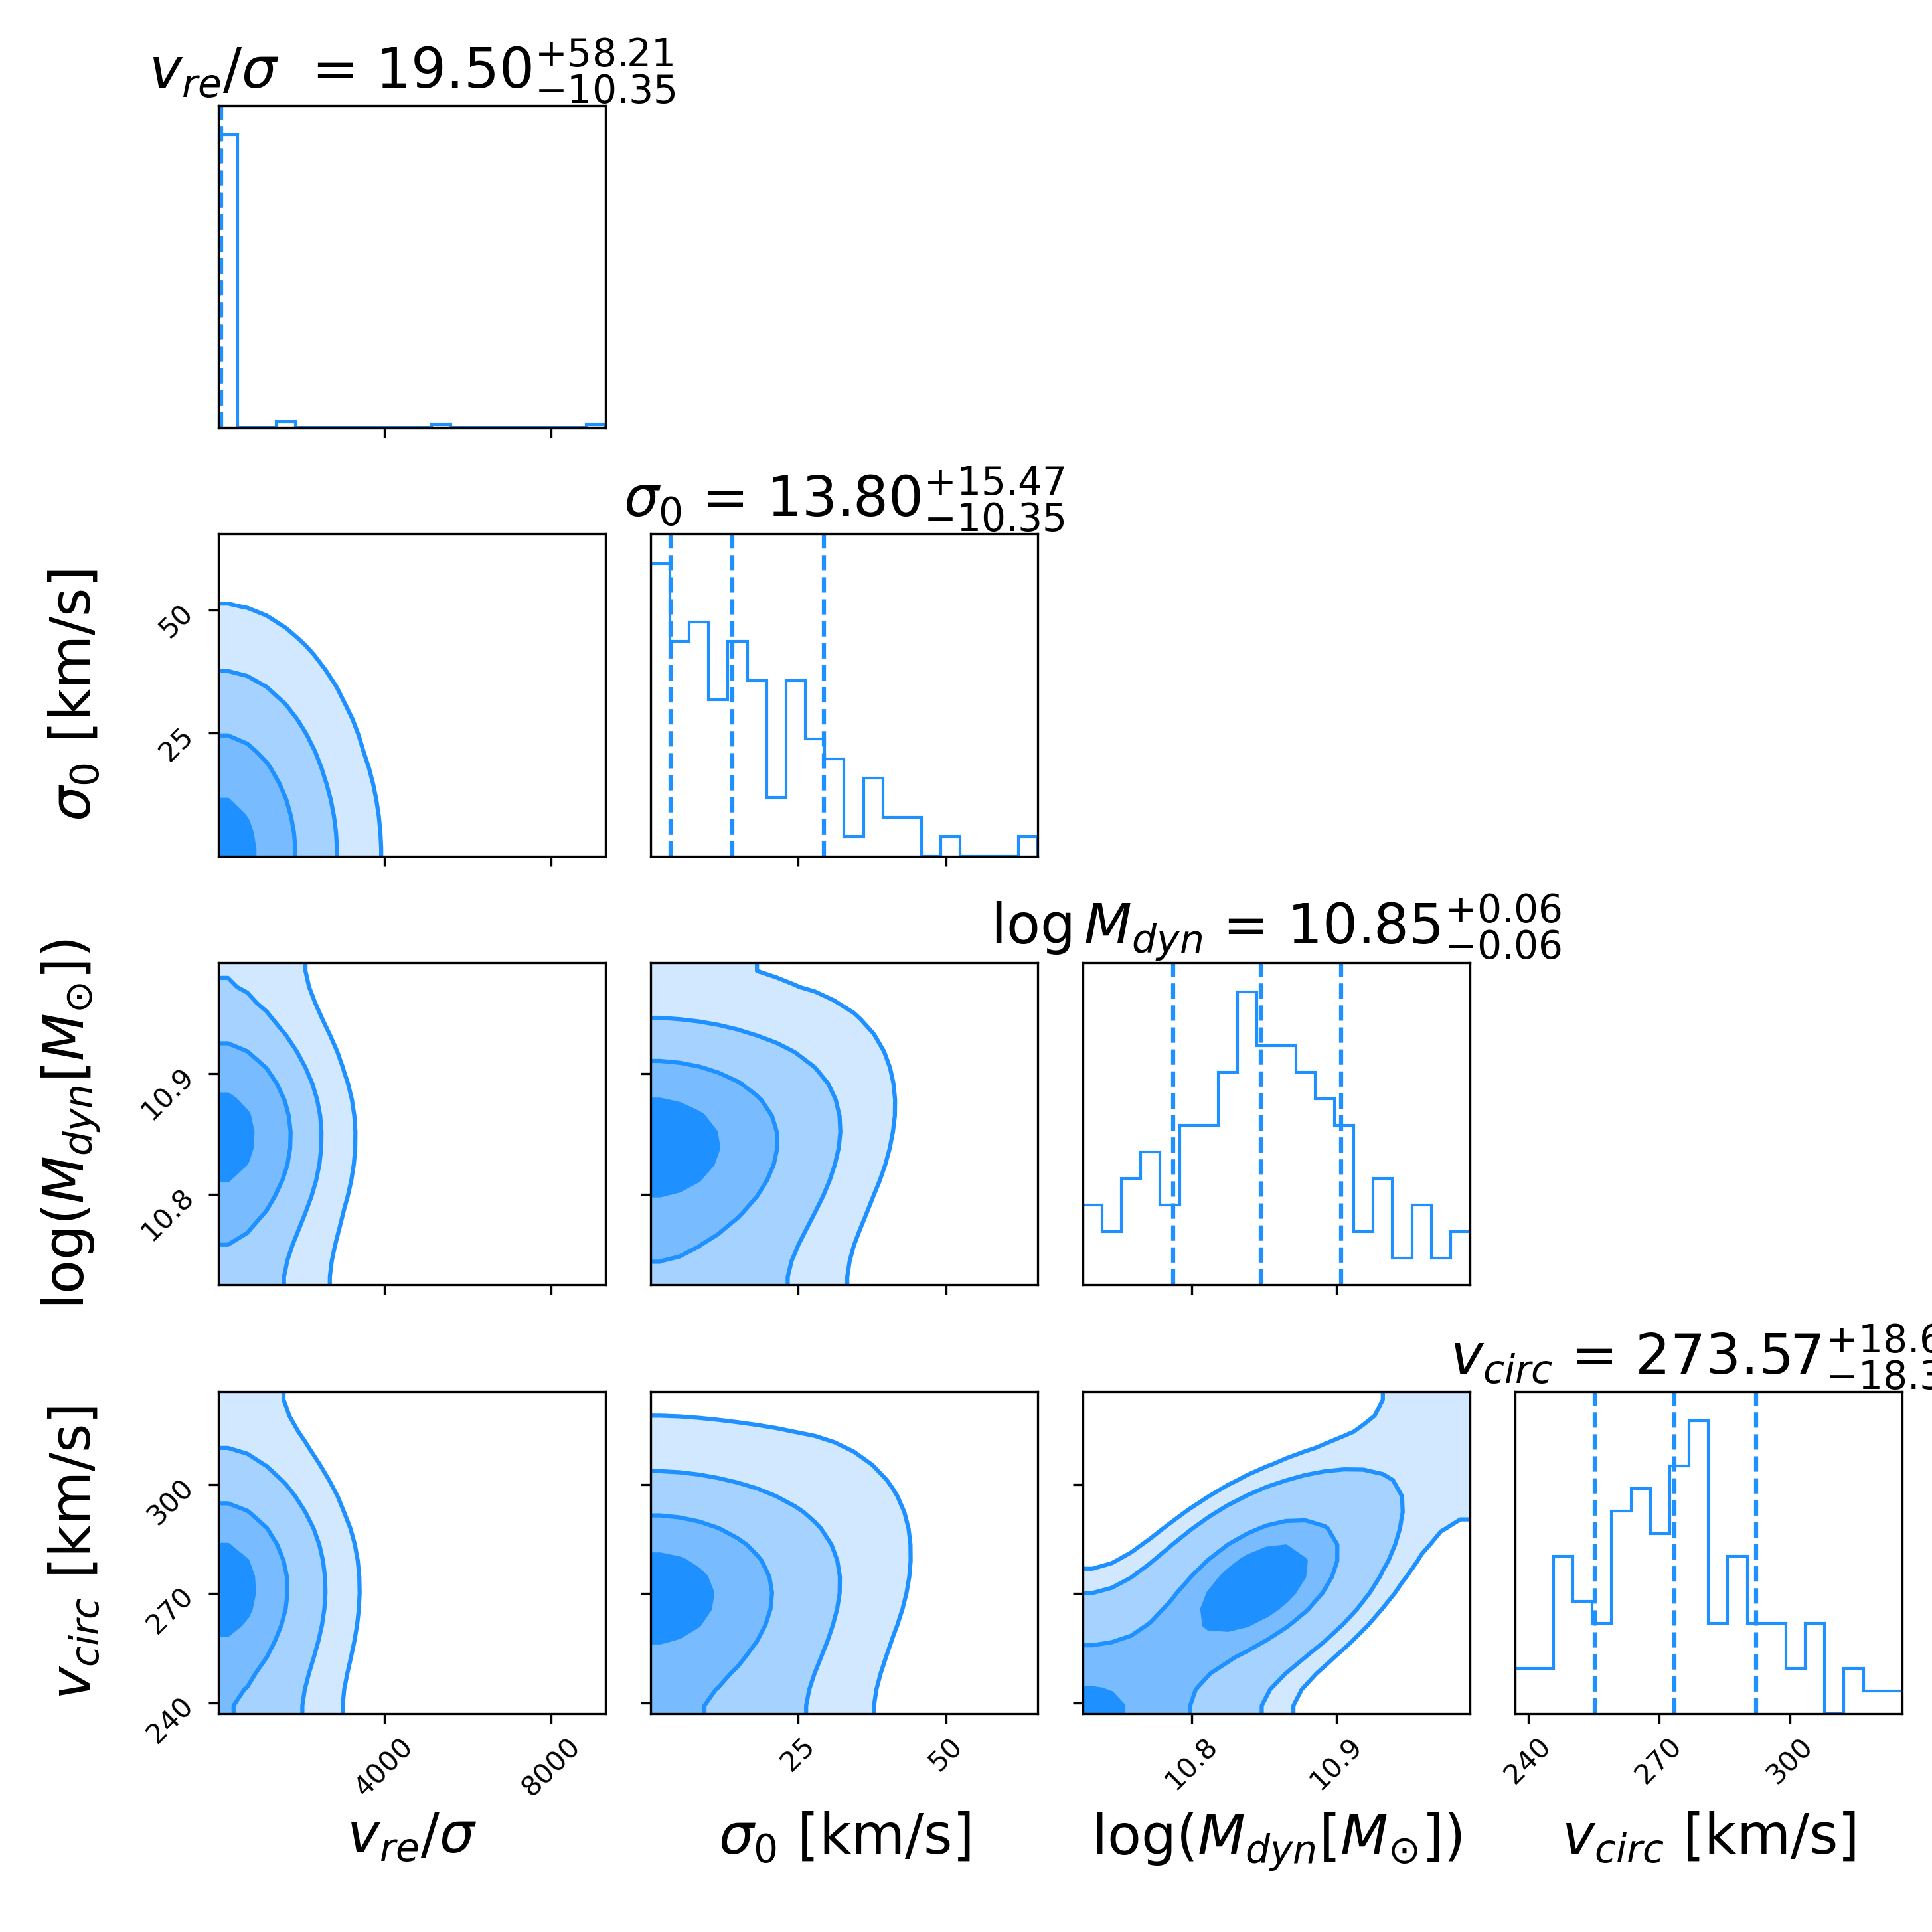

In [8]:
# Display the v/sigma corner plot
corner_plot = os.path.join(output_dir, f'{source_id}_v_sigma_corner.png')
if os.path.exists(corner_plot):
    print("\n" + "=" * 60)
    print("v/σ Posterior Distribution")
    print("=" * 60)
    display(Image(filename=corner_plot, width=600))
else:
    print(f"Corner plot not found: {corner_plot}")


Full Parameter Corner Plot


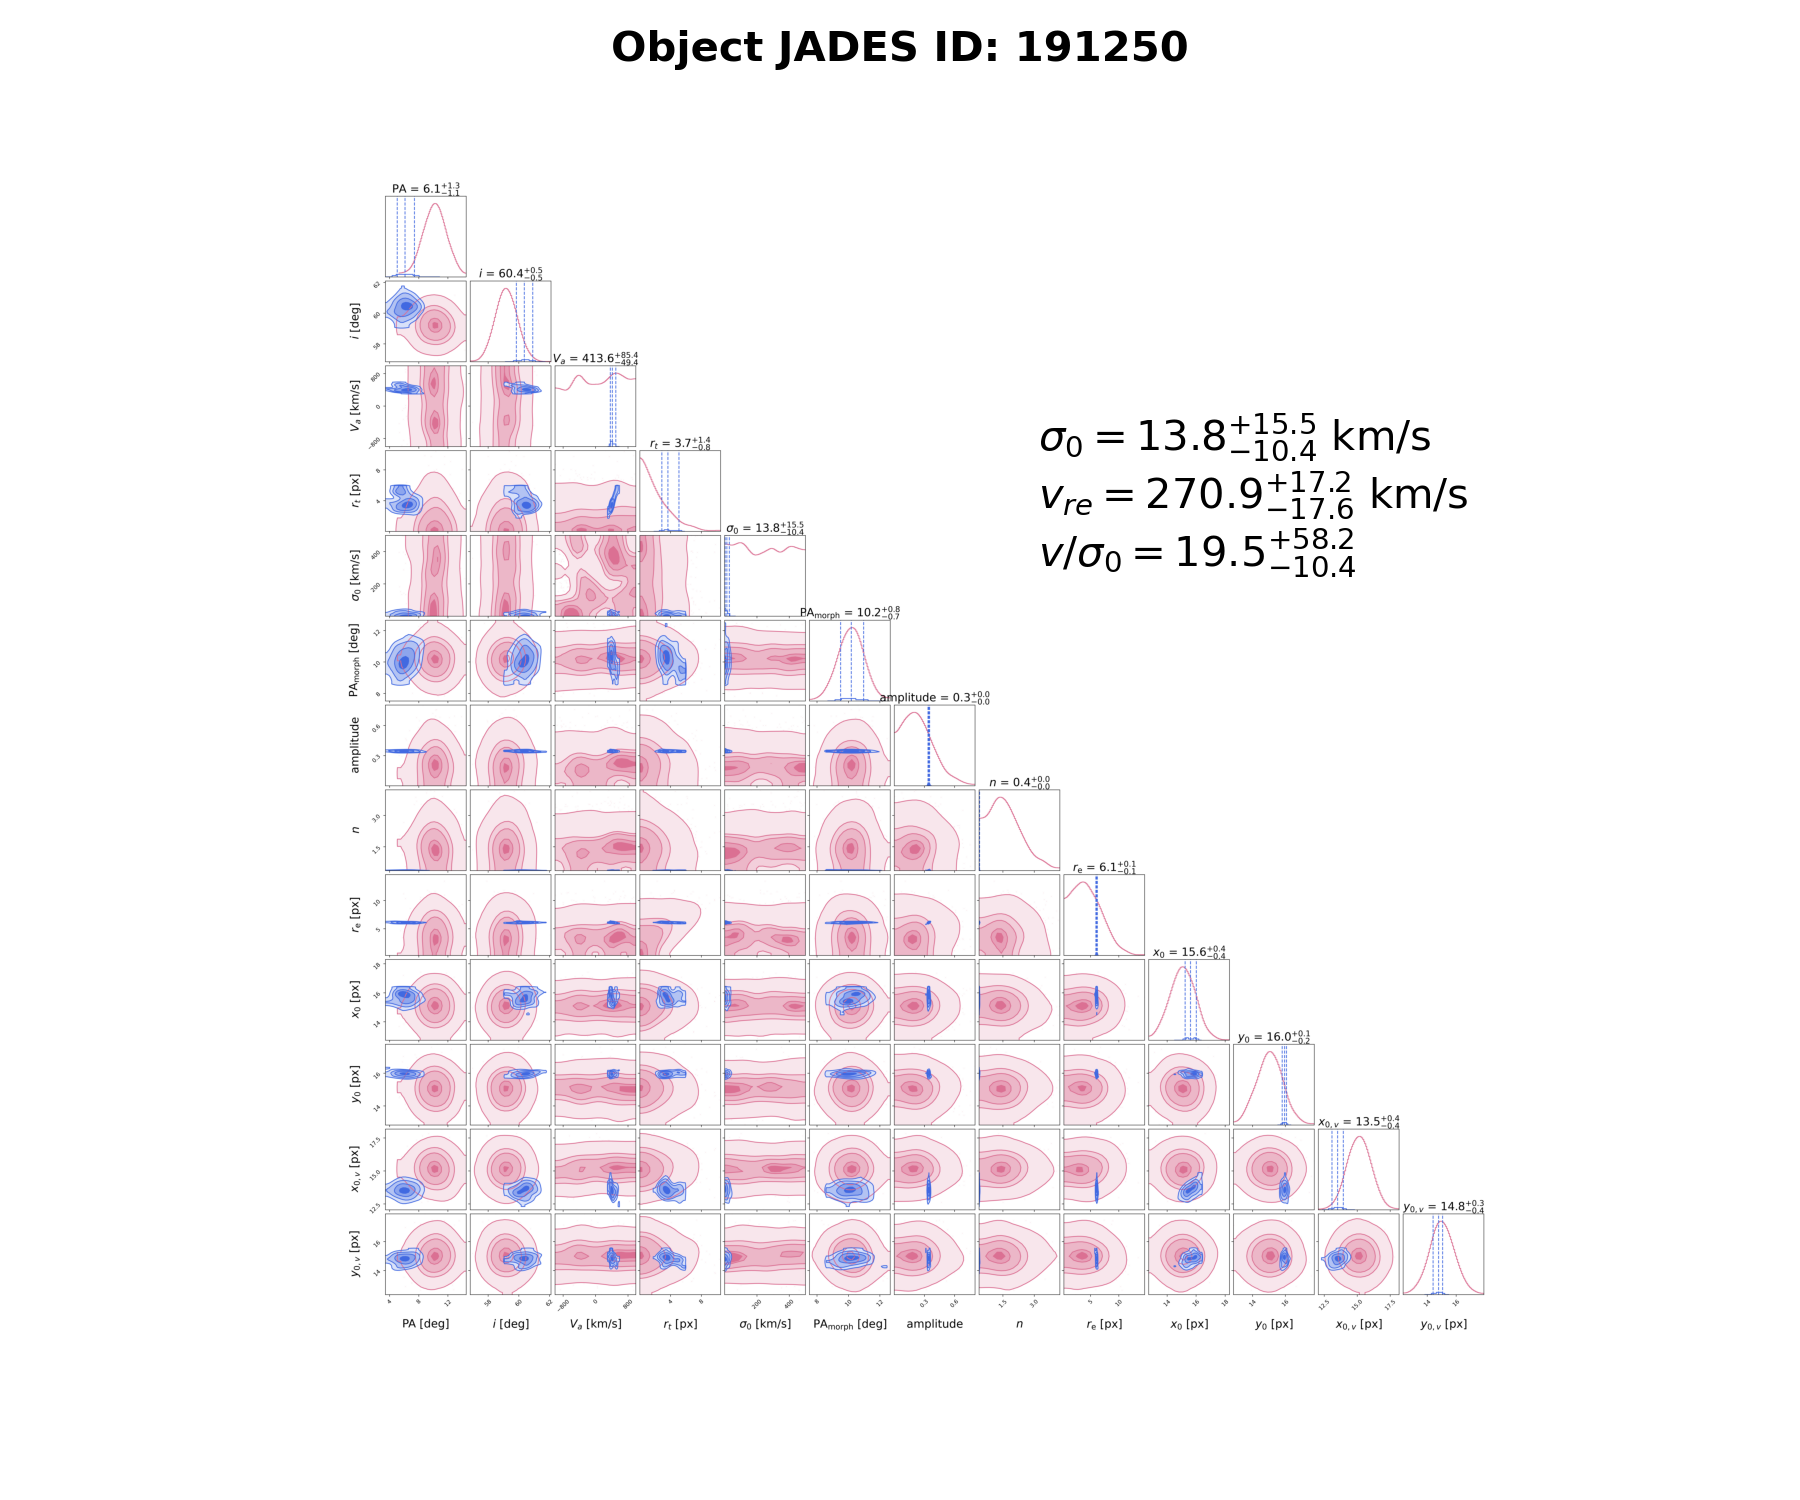

In [9]:
#plot the full cornerplot
corner_full_plot = os.path.join(output_dir, f'{source_id}_summary_corner.png')
if os.path.exists(corner_full_plot):
    print("\n" + "=" * 60)
    print("Full Parameter Corner Plot")
    print("=" * 60)
    display(Image(filename=corner_full_plot, width=800))


MCMC Trace Plots


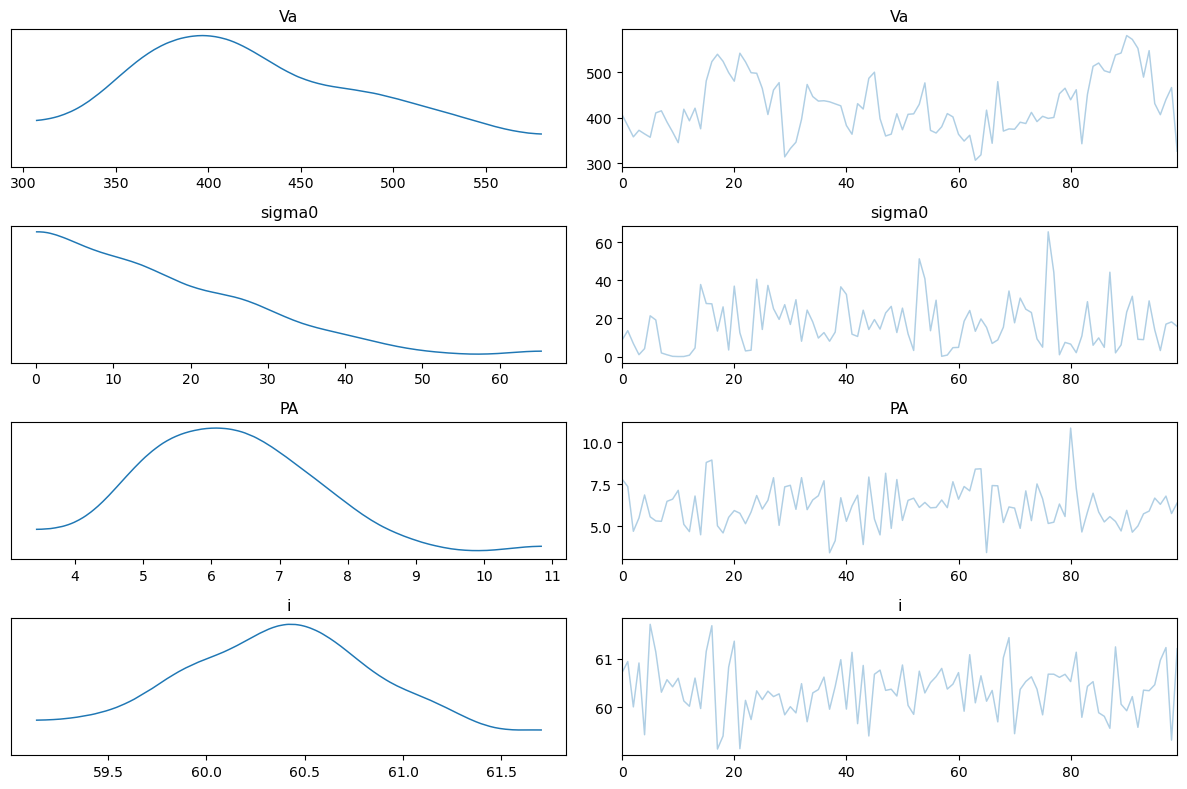

In [10]:
# Create additional diagnostic plots with arviz
print("\n" + "=" * 60)
print("MCMC Trace Plots")
print("=" * 60)

# Trace plots for key parameters
az.plot_trace(inference_data, var_names=['Va', 'sigma0', 'PA', 'i'])
plt.tight_layout()
plt.show()

## Key Output Parameters

The most important fitted parameters are:

**Kinematic Parameters:**
- `Va`: Asymptotic rotation velocity (km/s)
- `sigma0`: Central velocity dispersion (km/s)
- `v_re`: Rotation velocity at the effective radius (km/s) - derived quantity
- `r_t`: Turnover radius (pixels)

**Morphological Parameters:**
- `PA`: Position angle (degrees)
- `inc`: Inclination angle (degrees)
- `r_eff`: Effective radius (pixels)
- `n`: Sersic index
- `xc`, `yc`: Centroid coordinates (pixels)
- `amplitude`: Flux normalization

**Quality Metrics:**
- `r_hat`: Gelman-Rubin convergence diagnostic (should be < 1.01)
- `ess_bulk`: Effective sample size for bulk of distribution
- `ess_tail`: Effective sample size for tails of distribution

## Advanced: Using Custom Configuration

You can set custom priors using the `FitConfiguration` class. 

**Config contains:**
- **Morphology priors**: No defaults - must come from PySersic or manual specification
- **Kinematic priors**: Have defaults but can be overridden
- **MCMC settings**: Have defaults but can be overridden

**Scenario 1: You have PySersic fits (typical)**
- PySersic priors are loaded automatically for morphology
- You can optionally provide a config to override kinematic priors (Va, sigma0 ranges)
- Morphology stays from PySersic unless you explicitly set it in config

**Scenario 2: You don't have PySersic fits (rare)**
- You **must** provide a config with all morphology priors explicitly set
- Error will be raised if morphology priors are missing
- You can still override kinematic priors if desired

In [11]:
# Example 1: Override kinematic priors (you have PySersic fits)
# Only override the kinematic priors, keep PySersic morphology
from geko.config import FitConfiguration, KinematicPriors

config = FitConfiguration(
    kinematics=KinematicPriors(
        Va_min=50.0,        # Minimum asymptotic velocity (km/s)
        Va_max=300.0,       # Maximum asymptotic velocity (km/s)
        sigma0_min=10.0,    # Minimum velocity dispersion (km/s)
        sigma0_max=150.0    # Maximum velocity dispersion (km/s)
    )
)

# Morphology is None - will use PySersic values automatically
print("Kinematic priors will be overridden, morphology will come from PySersic")
config.print_summary()

# Run fit - PySersic morphology + custom kinematic priors
# inference_data_custom = run_geko_fit(
#     output=output_name,
#     master_cat=master_catalog,
#     line=emission_line,
#     parametric=parametric,
#     save_runs_path=save_runs_path,
#     num_chains=num_chains,
#     num_warmup=num_warmup,
#     num_samples=num_samples,
#     source_id=source_id,
#     field=field,
#     config=config,  # Kinematic override only
#     manual_psf_name=manual_psf_name,
#     manual_theta_rot=manual_theta_rot,
#     manual_pysersic_file=manual_pysersic_file,
#     manual_grism_file=manual_grism_file
# )

Kinematic priors will be overridden, morphology will come from PySersic
Geko Configuration Summary

Morphology Priors:
  Not set (will use PySersic priors)

Kinematic Priors:
  Va_min: 50.0 (default: -1000)
  Va_max: 300.0 (default: 1000)
  sigma0_min: 10.0 (default: 0)
  sigma0_max: 150.0 (default: 500.0)

MCMC Settings:
  num_chains: 4
  num_warmup: 500
  num_samples: 1000
  target_accept_prob: 0.8
  max_tree_depth: 10
  step_size: 0.1


In [12]:
# Example 2: Complete config with morphology (no PySersic available)
# Set all morphology manually but keep the default kinematic priors
from geko.config import MorphologyPriors

config_full = FitConfiguration(
    morphology=MorphologyPriors(
        # Position angle (degrees) - normal prior
        PA_mean=90.0,
        PA_std=30.0,
        # Inclination (degrees) - truncated normal prior
        inc_mean=55.0,
        inc_std=15.0,
        # Effective radius (pixels) - truncated normal
        r_eff_mean=3.0,
        r_eff_std=1.0,
        r_eff_min=0.5,
        r_eff_max=10.0,
        # Sersic index - truncated normal
        n_mean=1.0,
        n_std=0.5,
        n_min=0.5,
        n_max=4.0,
        # Central coordinates (pixels) - normal
        xc_mean=0.0,
        xc_std=2.0,
        yc_mean=0.0,
        yc_std=2.0,
        # Amplitude - truncated normal
        amplitude_mean=100.0,
        amplitude_std=50.0,
        amplitude_min=1.0,
        amplitude_max=1000.0
    )
)

print("\nComplete config set - can run without PySersic file")
config_full.print_summary()

# This would work even without a PySersic file
# Run fit with complete morphology config
# inference_data_full = run_geko_fit(
#     output=output_name,
#     master_cat=master_catalog,
#     line=emission_line,
#     parametric=parametric,
#     save_runs_path=save_runs_path,
#     num_chains=num_chains,
#     num_warmup=num_warmup,
#     num_samples=num_samples,
#     source_id=source_id,
#     field=field,
#     config=config_full,  # Complete morphology config
#     manual_psf_name=manual_psf_name,
#     manual_theta_rot=manual_theta_rot,
#     manual_pysersic_file=manual_pysersic_file,
#     manual_grism_file=manual_grism_file
# )


Complete config set - can run without PySersic file
Geko Configuration Summary

Morphology Priors:
  PA_mean: 90.0
  PA_std: 30.0
  inc_mean: 55.0
  inc_std: 15.0
  r_eff_mean: 3.0
  r_eff_std: 1.0
  r_eff_min: 0.5
  r_eff_max: 10.0
  n_mean: 1.0
  n_std: 0.5
  n_min: 0.5
  n_max: 4.0
  xc_mean: 0.0
  xc_std: 2.0
  yc_mean: 0.0
  yc_std: 2.0
  amplitude_mean: 100.0
  amplitude_std: 50.0
  amplitude_min: 1.0
  amplitude_max: 1000.0

Kinematic Priors:
  Va_min: -1000
  Va_max: 1000
  sigma0_min: 0
  sigma0_max: 500.0

MCMC Settings:
  num_chains: 4
  num_warmup: 500
  num_samples: 1000
  target_accept_prob: 0.8
  max_tree_depth: 10
  step_size: 0.1
